## Shape analysis on "trouble" regions
I put together this analysis to look at the "trouble" regions: the nodes that consistently appeared with a large difference between their theoretical and actual distances. For sphericity, I used:
\begin{equation}
\Psi = \frac{\pi^{\frac{1}{3}}(6V_p)^{\frac{2}{3}}}{A_p}
\end{equation}
Where $\Psi$ is a value between 0 and 1, 1 being a perfect sphere.

In [24]:
from allensdk.core.reference_space_cache import ReferenceSpaceCache
import trimesh
import math
a = ReferenceSpaceCache(25, 'annotation/ccf_2017', manifest='mouse_connectivity_manifest.json')

#region = 997
#[vertices, vertex_normals, faces, face_normals] = a.get_structure_mesh(region)

In [25]:
import pandas as pd
csv = '../../spreadsheets/Hypothalamic Optimization counts.csv'
# Pull data from spreadsheet on which regions are the trouble regions with counts of >5 over optimal distances
df = pd.read_csv(csv)
df = df.set_index('structure-id')
# Create new column for mesh data gathered from API
df['mesh data'] = pd.np.nan
df['mesh data'] = df['mesh data'].astype('object')

In [26]:
# Retrieve mesh data from ABA
# Mesh data for each region is in the form [vertices, vertex_normals, faces, face_normals]
df['mesh data'] = df.apply(lambda x: a.get_structure_mesh(x.name), axis=1)

In [27]:
# Function to make a mesh from mesh data + give it a pretty color
def manage_meshes(x):
    m = trimesh.Trimesh(vertices=x[0], faces=x[2])
    m.visual.vertex_colors = trimesh.visual.random_color()
    return m    

### This render shows all the regions which have an "optimal distance" > 5 away from their actual distance.

In [38]:
meshes = []
# Make a new mesh column
df['mesh'] = pd.np.nan
df['mesh'] = df['mesh'].astype('object')
# Turn mesh data into actual meshes
df['mesh'] = df['mesh data'].apply(lambda x: manage_meshes(x))
# Combine all the meshes into one scene and show only the problem meshes
meshes = list(df.mesh.loc[df['Counts in distance>5'] > 0])
trimesh.Scene(meshes).show()
#trimesh.scene.scene.append_scenes(scenes).show()

In [29]:
# Compute sphericity for each region
df['sphericity'] = pd.np.nan
df['sphericity'] = df.mesh.apply(lambda x: pow(math.pi, 1/3)*pow(6*x.volume, 2/3) / x.area)
df.head(5)
# Convert area and volume to mm3
#print('Characteristics for Region [%s]:\nArea: %f, Volume: %f, Sphericity: %f' % (region_name, mesh.area / 1e9, mesh.volume / 1e9, sphericity))

,structure-abbrev,structure-name,Counts in distance>5,mesh data,mesh,sphericity
structure-id,,,,,,
194,LHA,Lateral hypothalamic area,7,"([[6411.11, 5722.05, 3949.76], [6429.5, 5755.1...","<trimesh.Trimesh(vertices.shape=(1672, 3), fac...",0.596850
491,MM,Medial mammillary nucleus,6,"([[7825.21, 6114.52, 4885.32], [7761.12, 6146....","<trimesh.Trimesh(vertices.shape=(466, 3), face...",0.862521
88,AHN,Anterior hypothalamic nucleus,6,"([[6135.11, 6385.92, 4781.21], [6107.16, 6340....","<trimesh.Trimesh(vertices.shape=(713, 3), face...",0.702415
830,DMH,Dorsomedial nucleus of the hypothalamus,6,"([[6922.23, 5892.83, 5016.06], [6871.93, 5948....","<trimesh.Trimesh(vertices.shape=(477, 3), face...",0.675669
210,LM,Lateral mammillary nucleus,5,"([[7890.32, 6192.88, 4556.79], [7885.65, 6151....","<trimesh.Trimesh(vertices.shape=(168, 3), face...",0.706209


### The number of times a node appears in an edge that is > 5 away from the optimal as a function of sphericity:

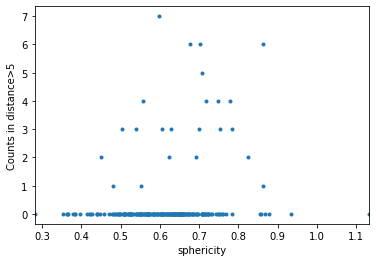

In [30]:
ax = df.plot(x='sphericity', y='Counts in distance>5', style='.')
ax.get_legend().remove()
ax.set_ylabel('Counts in distance>5')
ax.get_figure().savefig('./sphericity graphs/distance counts vs sphericity.pdf')

In [31]:
edges_df = pd.read_csv('../../spreadsheets/Hypothalamic Optimization Distances.csv')
edges_df['distance from true'] = abs(edges_df['distance from true'])
#edges_df.head(5)

In [32]:
edges_df['sphericity1'] = edges_df.n1.apply(lambda x: df.sphericity.loc[x])
edges_df['sphericity2'] = edges_df.n2.apply(lambda x: df.sphericity.loc[x])
edges_df['sphericity comb'] = edges_df['sphericity1'] * edges_df['sphericity2']
edges_df.tail(5)

,n1,n2,intensity,distance,R1+R2,opt. distance,distance from true,structure-name,structure-name.1,sphericity1,sphericity2,sphericity comb
644,525,946,5298.104492,0.623699,0.945918,13.936138,13.312440,Supramammillary nucleus,Posterior hypothalamic nucleus,0.557831,0.692563,0.386333
645,88,515,10758.870120,0.620484,1.012361,14.659671,14.039188,Anterior hypothalamic nucleus,Medial preoptic nucleus,0.702415,0.717332,0.503865
646,515,88,6456.455100,0.620484,1.012361,14.661512,14.041028,Medial preoptic nucleus,Anterior hypothalamic nucleus,0.717332,0.702415,0.503865
647,523,515,9591.381836,0.584893,0.969232,14.717813,14.132919,Medial preoptic area,Medial preoptic nucleus,0.504088,0.717332,0.361598
648,515,523,8042.708496,0.584893,0.969232,14.724646,14.139753,Medial preoptic nucleus,Medial preoptic area,0.717332,0.504088,0.361598


### Combined sphericity (defined as the multipled sphericities of both nodes in an edge) as a function of optimal distance from true value:

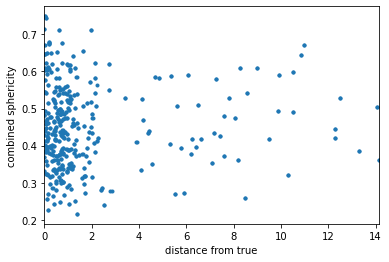

In [33]:
graph = edges_df.plot(x='distance from true', y='sphericity comb', style='.')
graph.get_legend().remove()
graph.set_ylabel('combined sphericity')
graph.get_figure().savefig('./sphericity graphs/combined sphericity vs distance from true.pdf')

### Edge with the minimum combined sphericity:

In [34]:
# Edge with the minimum combined sphericity
edges_df[edges_df['sphericity comb'] == edges_df['sphericity comb'].min()]

,n1,n2,intensity,distance,R1+R2,opt. distance,distance from true,structure-name,structure-name.1,sphericity1,sphericity2,sphericity comb
64,390,797,1581.217285,2.255504,0.978343,0.886341,1.369164,Supraoptic nucleus,Zona incerta,0.450536,0.479188,0.215891
65,797,390,1319.429932,2.255504,0.978343,0.886380,1.369124,Zona incerta,Supraoptic nucleus,0.479188,0.450536,0.215891


### Edge with the maximum combined sphericity:

In [35]:
# Edge with the maximum combined sphericity
edges_df[edges_df['sphericity comb'] == edges_df['sphericity comb'].max()]

,n1,n2,intensity,distance,R1+R2,opt. distance,distance from true,structure-name,structure-name.1,sphericity1,sphericity2,sphericity comb
460,272,38,573.364319,3.517911,0.707998,3.487757,0.030154,Anteroventral periventricular nucleus,Paraventricular hypothalamic nucleus,0.863592,0.867264,0.748962
465,38,272,1795.034180,3.517911,0.707998,3.493854,0.024057,Paraventricular hypothalamic nucleus,Anteroventral periventricular nucleus,0.867264,0.863592,0.748962


### Edge with the maximum distance from the true value:

In [36]:
edges_df[edges_df['distance from true'] == edges_df['distance from true'].max()]

,n1,n2,intensity,distance,R1+R2,opt. distance,distance from true,structure-name,structure-name.1,sphericity1,sphericity2,sphericity comb
648,515,523,8042.708496,0.584893,0.969232,14.724646,14.139753,Medial preoptic nucleus,Medial preoptic area,0.717332,0.504088,0.361598


### Edges containing the node that had the least sphericity:

In [37]:
# Edges with node that has the least sphericity
# Limited to first 5
edges_df[edges_df['sphericity1'] == edges_df['sphericity1'].min()].head(5)

,n1,n2,intensity,distance,R1+R2,opt. distance,distance from true,structure-name,structure-name.1,sphericity1,sphericity2,sphericity comb
0,390,347,0.000000,5.952730,0.520410,3.415775,2.536956,Supraoptic nucleus,Subparaventricular zone,0.450536,0.532664,0.239984
42,390,210,505.553223,2.011219,0.487952,0.308328,1.702890,Supraoptic nucleus,Lateral mammillary nucleus,0.450536,0.706209,0.318172
56,390,946,713.264282,2.315599,0.776279,0.710800,1.604799,Supraoptic nucleus,Posterior hypothalamic nucleus,0.450536,0.692563,0.312025
64,390,797,1581.217285,2.255504,0.978343,0.886341,1.369164,Supraoptic nucleus,Zona incerta,0.450536,0.479188,0.215891
72,390,525,488.898376,2.198499,0.616889,0.879186,1.319314,Supraoptic nucleus,Supramammillary nucleus,0.450536,0.557831,0.251323
